In [43]:
import os
import pandas as pd

root_pth = '/home/ddon0001/PhD/experiments/misc/no_merges/'
ds_summary_path = os.path.join(root_pth, 'summary.csv')
ds_info = pd.read_csv(ds_summary_path)[['ds_name', 'det_path']]
overall_df = pd.read_csv(os.path.join(root_pth, 'all_edges_with_target.csv'))

In [38]:
# from tqdm import tqdm
# from _iterative_solve import load_sol_files
# from _iterative_sample import populate_target_label

# dfs = []
# for row in tqdm(ds_info.itertuples()):
#     # read all edges, solution graph, ground truth, sol_gt_mapping
#     sol_pth = os.path.join(root_pth, row.ds_name)
#     _, all_edges, solution_graph, gt_graph, _, sol_to_gt = load_sol_files(sol_pth)
#     # assign "edge_in_gt" and "is_correct" to all real edges
#     populate_target_label(all_edges, solution_graph, gt_graph, sol_to_gt)
#     all_edges['solution_correct'] = (all_edges.flow > 0) == (all_edges.oracle_is_correct)
#     all_edges['solution_incorrect'] = all_edges.solution_correct == False
#     all_edges['ds_name'] = row.ds_name
#     dfs.append(all_edges[(all_edges.u >= 0) & (all_edges.v >= 0)])
# overall_df = pd.concat(dfs)
# overall_df.to_csv(os.path.join(root_pth, 'all_edges_with_target.csv'), index=False)

26it [00:45,  1.76s/it]


In [44]:
plot_order = overall_df[overall_df.solution_incorrect].ds_name.value_counts().index

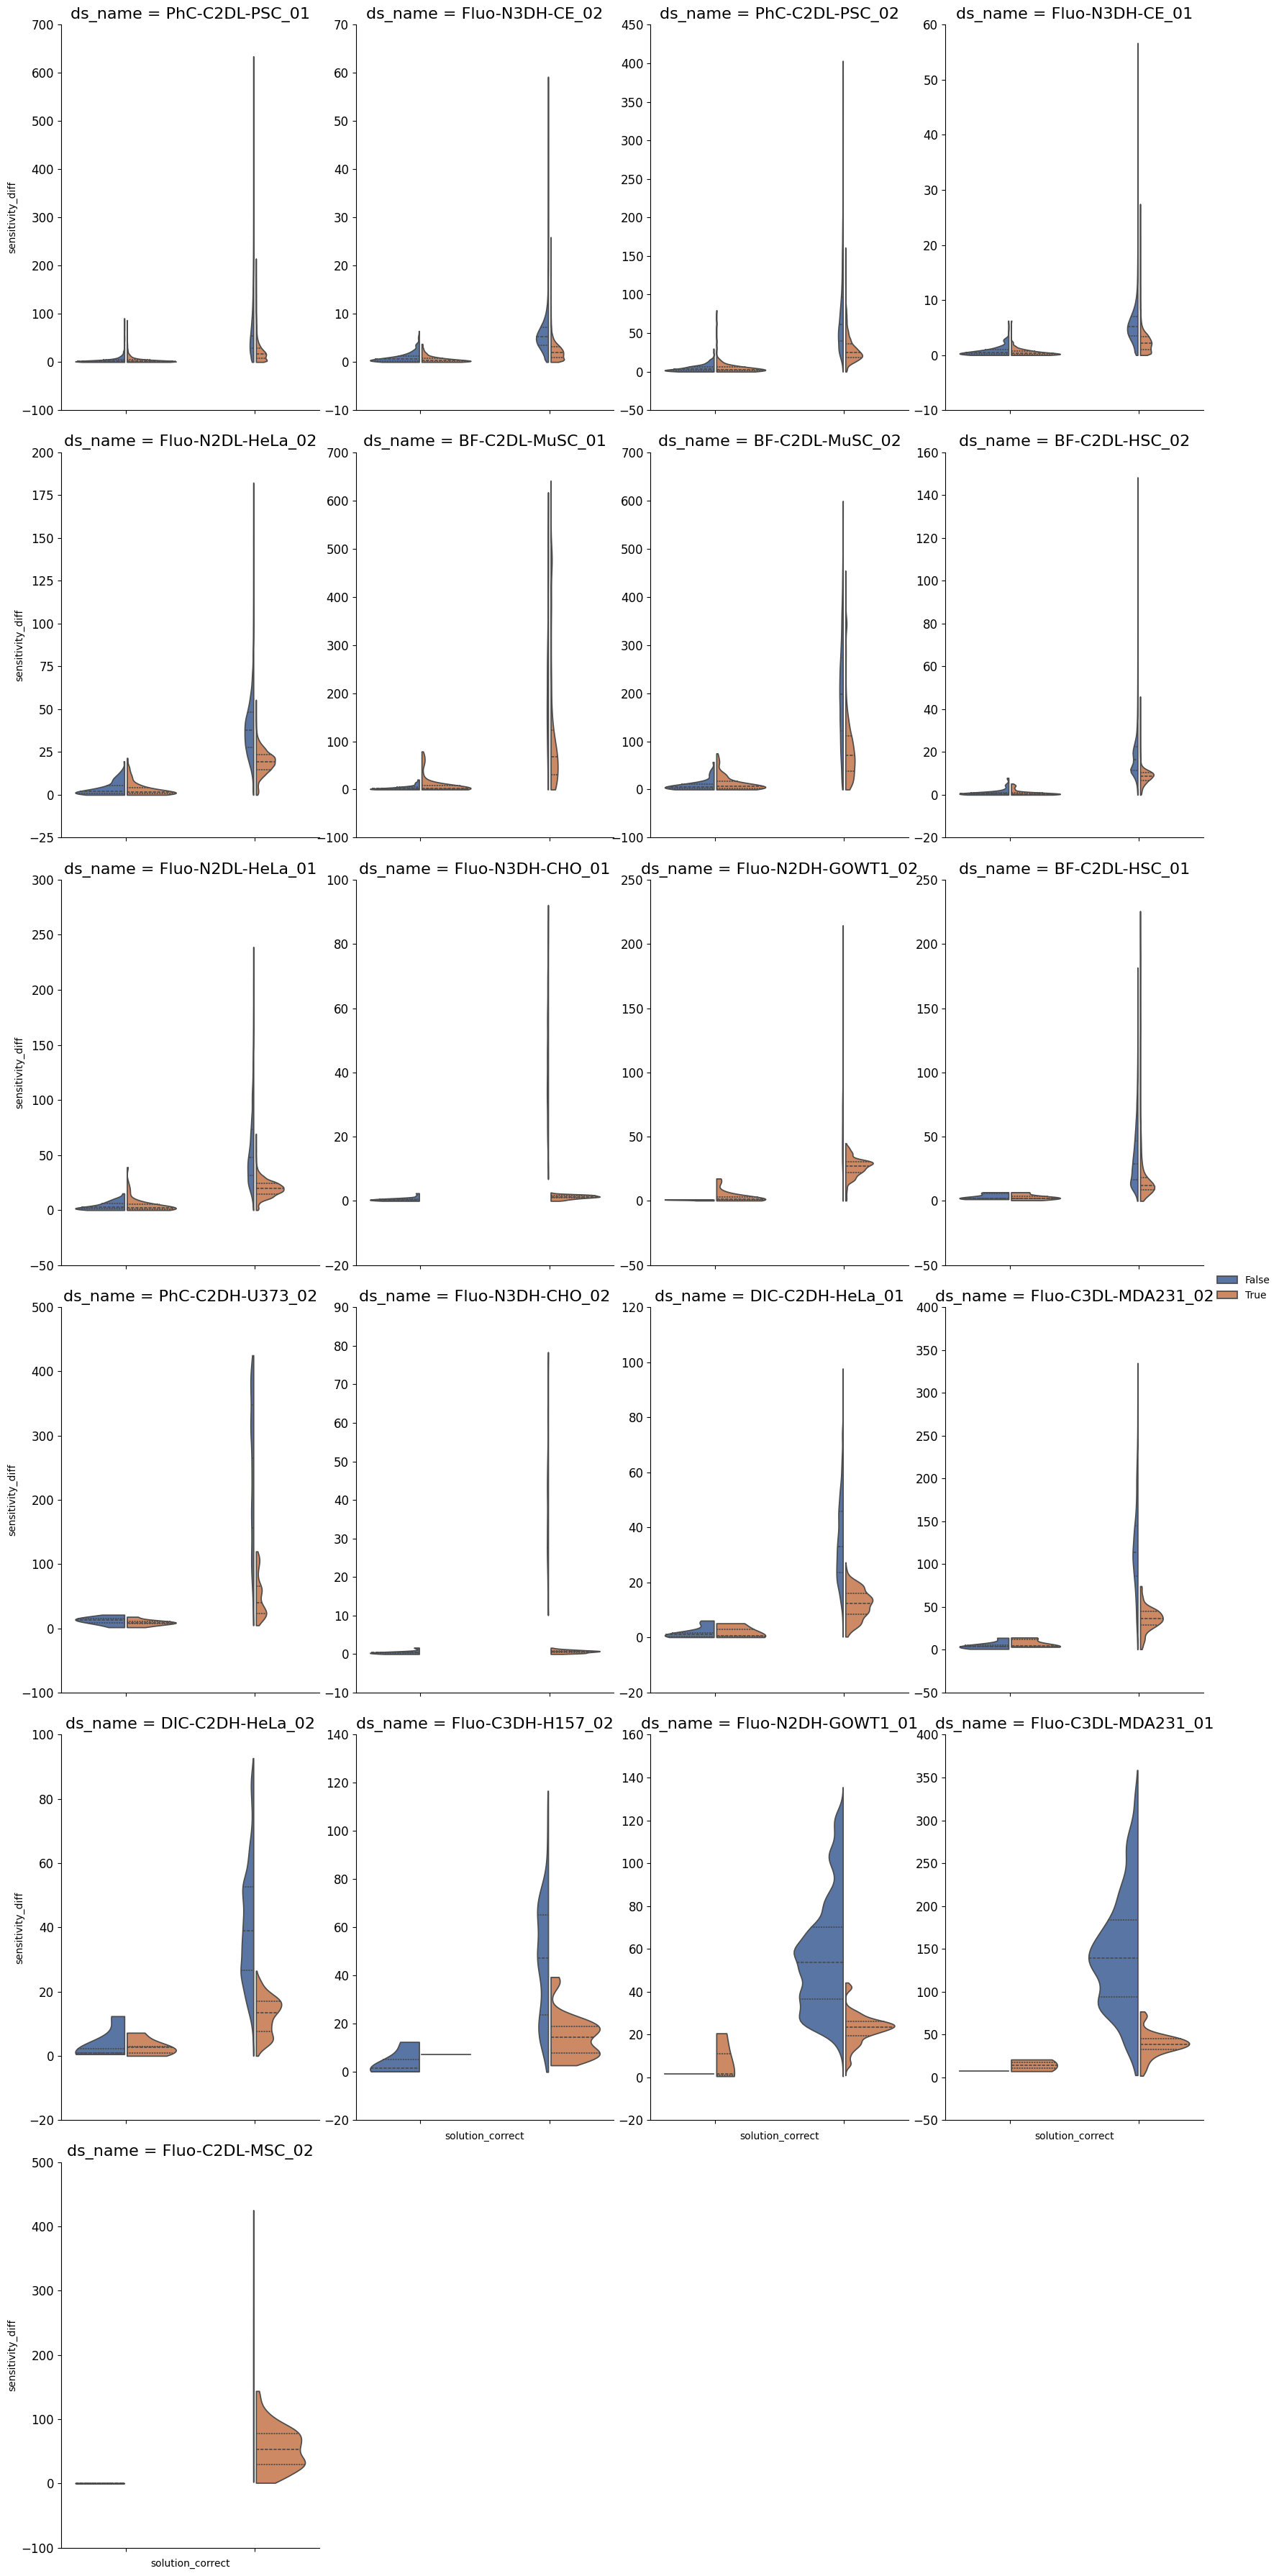

In [4]:
# plot sensitivity diff of is_correct edges vs. not is correct edges, split by flow >0 and flow =0 
import seaborn as sns

migration_only = overall_df[(overall_df.u >= 0) & (overall_df.v >= 0)]
migration_only['in_solution'] = migration_only.flow > 0
grid = sns.FacetGrid(migration_only, height=6, aspect=0.7, col='ds_name', col_wrap=4, sharex=True, sharey=False, col_order=plot_order)
grid.map_dataframe(sns.violinplot, x='solution_correct', y='sensitivity_diff', inner='quart', hue='in_solution', palette='deep', split=True, gap=0.05, cut=0)

grid.set_titles(size=16)
grid.set_axis_labels(size=14)
grid.set_xticklabels(size=12)
grid.set_yticklabels(size=12)
grid.add_legend()

In [ ]:
import numpy as np

# assign "prop diff column"
overall_df['chosen_neighbour_area_diff'] = (overall_df['chosen_neighbour_area_prop'] - 1).abs()

info_dict = {
    'col_name': ['distance', 'chosen_neighbour_rank', 'chosen_neighbour_area_diff', 'sensitivity_diff'],
    'ascending': [False, False, False, True],
    'prefix': ['dist', 'rank', 'area', 'sens']
}
no_errors = []

to_join = {prefix: [] for prefix in info_dict['prefix']}
for row in ds_info.itertuples():
    ds_name = row.ds_name
    ds_edges = overall_df[overall_df.ds_name == ds_name]
    ds_in_solution = ds_edges[(ds_edges.u >= 0) & (ds_edges.v >= 0) & (ds_edges.flow > 0)]
    count_edges_in_solution = len(ds_in_solution)
    count_errors_in_solution = ds_in_solution['solution_incorrect'].sum()
    if count_errors_in_solution == 0:
        print("No errors in solution for", ds_name)
        no_errors.append(ds_name)
        continue

    # each edge represents a proportion of all edges
    ds_in_solution['single_edge_sample_prop'] = 1/count_edges_in_solution
    # each edge that's incorrect contributes a certain proportion to all error
    ds_in_solution['edge_error_prop'] = ds_in_solution['solution_incorrect'] / count_errors_in_solution if count_errors_in_solution else 0

    for i in range(4):
        col_name = info_dict['col_name'][i]
        ascending = info_dict['ascending'][i]
        prefix = info_dict['prefix'][i]

        # sort by the column and ascending
        sorted_in_solution = ds_in_solution.sort_values(by=col_name, ascending=ascending)

        # compute cumulative values, assign using prefix
        sorted_in_solution[f'{prefix}_prop_edges_presented'] = sorted_in_solution.single_edge_sample_prop.cumsum()
        sorted_in_solution[f'{prefix}_prop_errors_presented'] = sorted_in_solution.edge_error_prop.cumsum()
        sorted_in_solution[f'{prefix}_prop_sampled_incorrect'] = sorted_in_solution.solution_incorrect.cumsum() / np.ones(count_edges_in_solution, dtype=int).cumsum()

        # save columns to join back in
        to_join[prefix].append(sorted_in_solution[[f'{prefix}_prop_edges_presented', f'{prefix}_prop_errors_presented', f'{prefix}_prop_sampled_incorrect']])

In [52]:
with_errors = overall_df[~overall_df.ds_name.isin(no_errors)]
with_errors_in_solution = with_errors[(with_errors.u >= 0) & (with_errors.v >= 0) & (with_errors.flow > 0)]
for prefix, dfs in to_join.items():
    joined = pd.concat(dfs)
    with_errors_in_solution = with_errors_in_solution.join(joined)
with_errors_in_solution.to_csv(os.path.join(root_pth, 'errors_sample_props_in_solution.csv'), index=False)

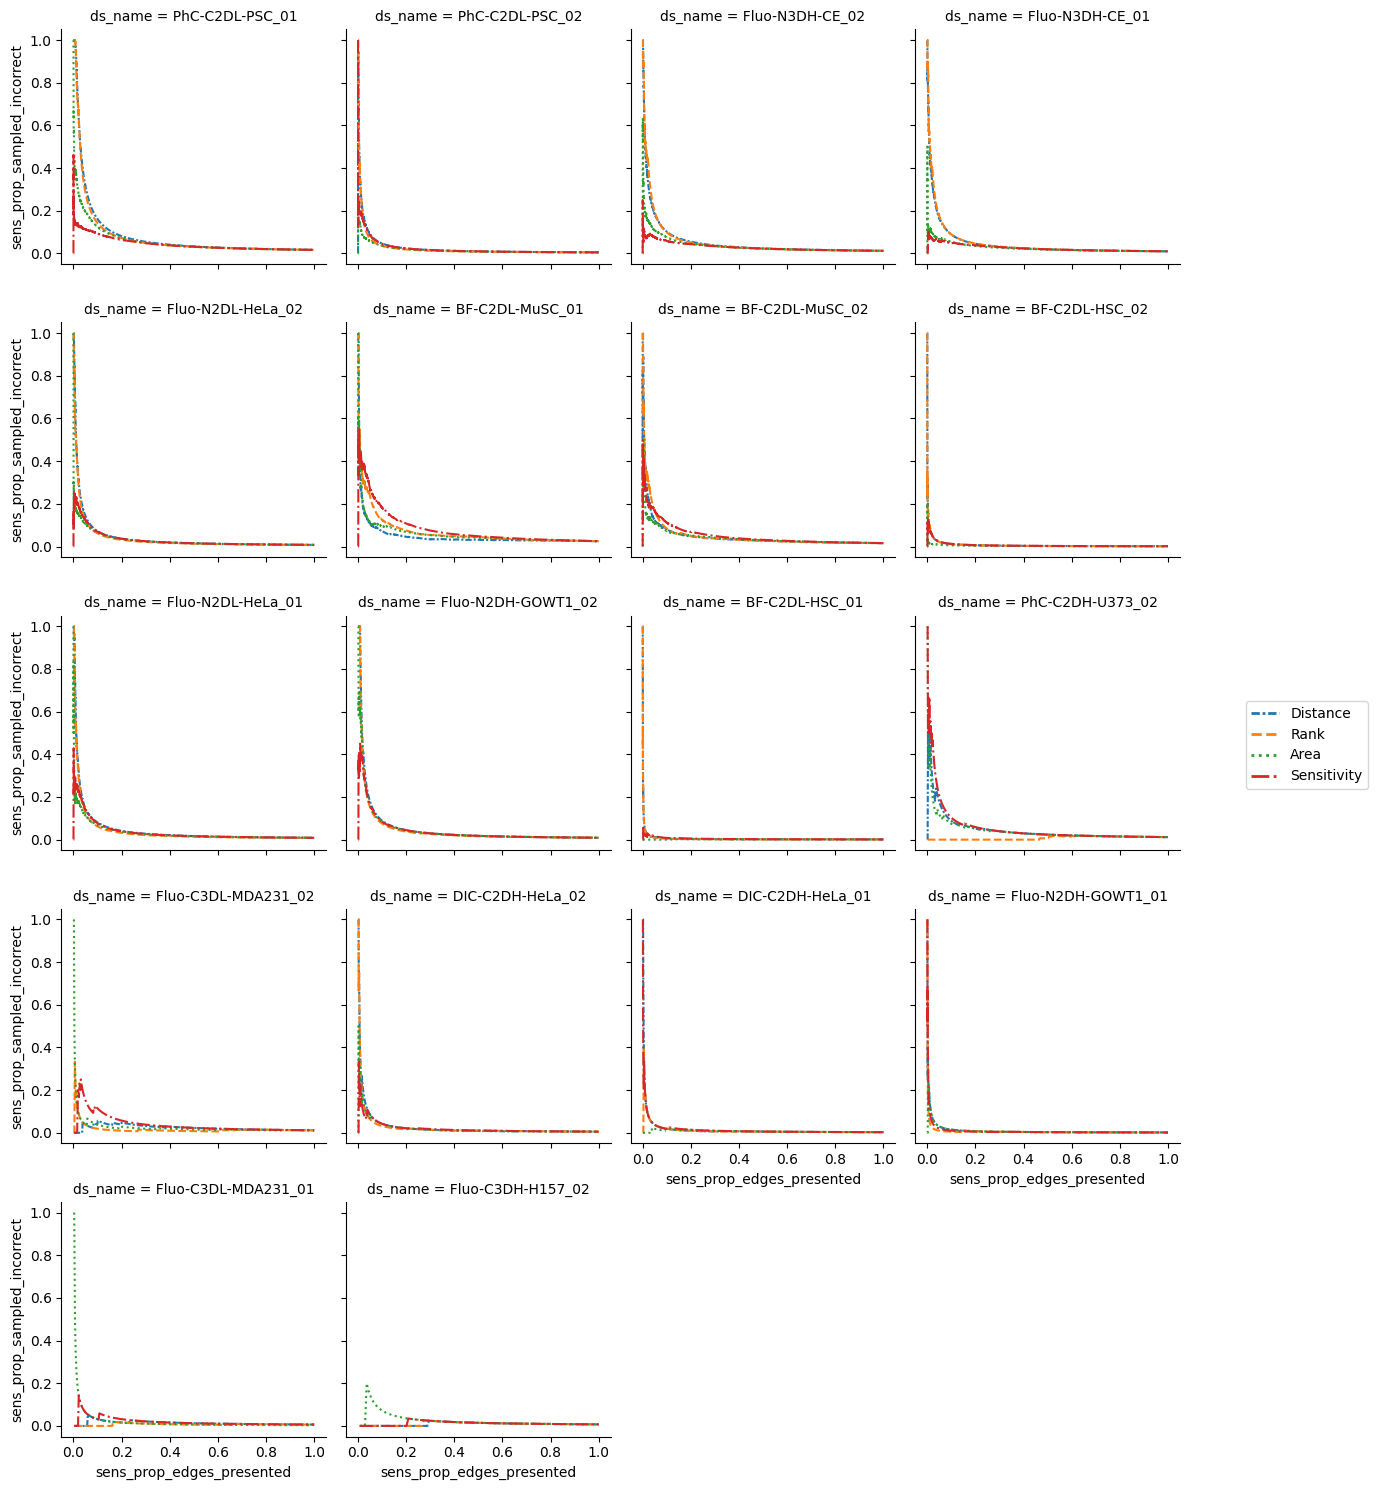

In [70]:
import seaborn as sns
from matplotlib.lines import Line2D

errors_plot_order = with_errors_in_solution[with_errors_in_solution.solution_incorrect].ds_name.value_counts().index
grid = sns.FacetGrid(with_errors_in_solution, col='ds_name', col_wrap=4, sharex=True, sharey=True, col_order=errors_plot_order)
# grid.map_dataframe(sns.lineplot, x='dist_prop_edges_presented', y='dist_prop_errors_presented', color=sns.color_palette()[0])
grid.map_dataframe(sns.lineplot, x='dist_prop_edges_presented', y='dist_prop_sampled_incorrect', color=sns.color_palette()[0], linestyle=(0, (3, 1, 1, 1)))
# grid.map_dataframe(sns.lineplot, x='rank_prop_edges_presented', y='rank_prop_errors_presented', color=sns.color_palette()[1])
grid.map_dataframe(sns.lineplot, x='rank_prop_edges_presented', y='rank_prop_sampled_incorrect', color=sns.color_palette()[1], linestyle='--')
# grid.map_dataframe(sns.lineplot, x='area_prop_edges_presented', y='area_prop_errors_presented', color=sns.color_palette()[2])
grid.map_dataframe(sns.lineplot, x='area_prop_edges_presented', y='area_prop_sampled_incorrect', color=sns.color_palette()[2], linestyle=':')
# grid.map_dataframe(sns.lineplot, x='sens_prop_edges_presented', y='sens_prop_errors_presented', color=sns.color_palette()[3])
grid.map_dataframe(sns.lineplot, x='sens_prop_edges_presented', y='sens_prop_sampled_incorrect', color=sns.color_palette()[3], linestyle='-.')
# Create custom legend labels
custom_lines = [
    Line2D([0], [0], color=sns.color_palette()[0], lw=2, linestyle=(0, (3, 1, 1, 1))),
    Line2D([0], [0], color=sns.color_palette()[1], lw=2, linestyle='--'),
    Line2D([0], [0], color=sns.color_palette()[2], lw=2, linestyle=':'),
    Line2D([0], [0], color=sns.color_palette()[3], lw=2, linestyle='-.')
]

# Add legend to the figure
grid.figure.legend(custom_lines, ['Distance', 'Rank', 'Area', 'Sensitivity'], loc='center right', bbox_to_anchor=(1.15, 0.5))

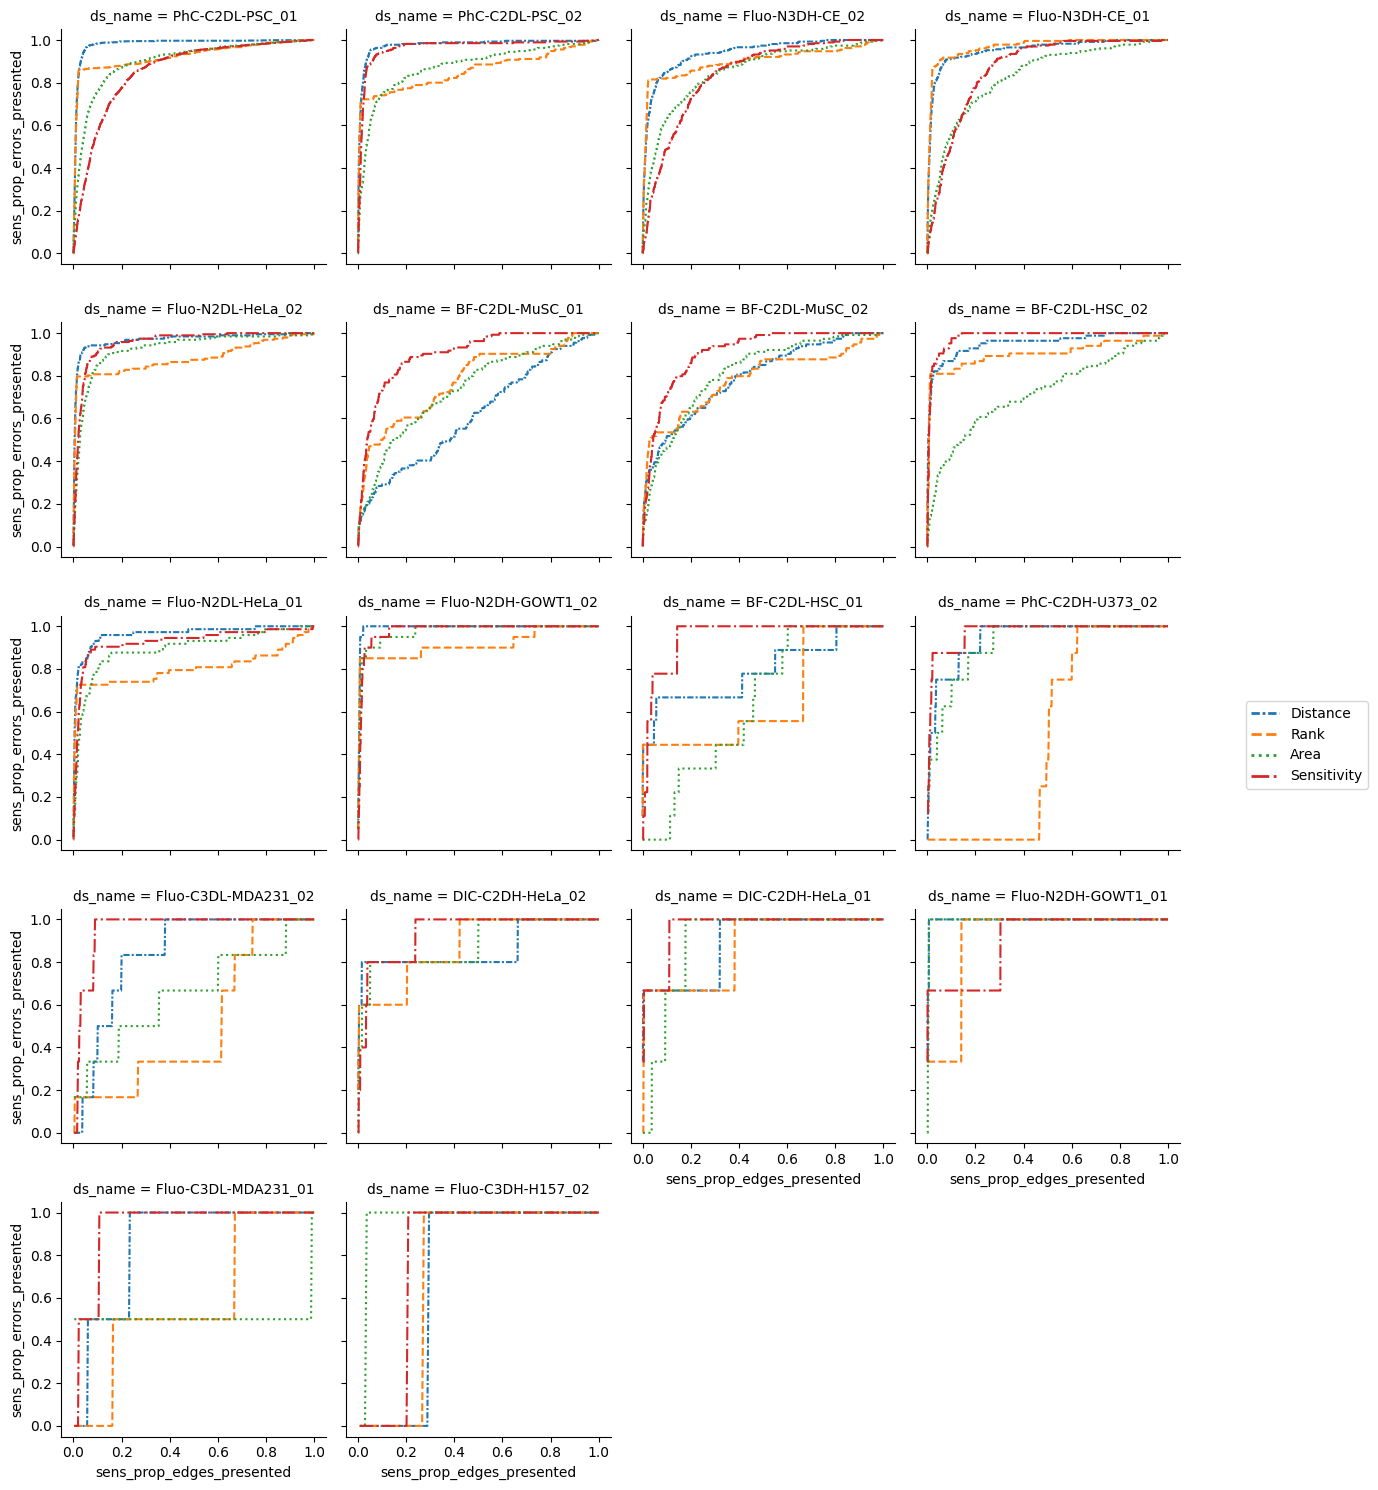

In [69]:
import seaborn as sns
from matplotlib.lines import Line2D

errors_plot_order = with_errors_in_solution[with_errors_in_solution.solution_incorrect].ds_name.value_counts().index
grid = sns.FacetGrid(with_errors_in_solution, col='ds_name', col_wrap=4, sharex=True, sharey=True, col_order=errors_plot_order)
# blue
grid.map_dataframe(sns.lineplot, x='dist_prop_edges_presented', y='dist_prop_errors_presented', color=sns.color_palette()[0], linestyle=(0, (3, 1, 1, 1)))

# orange
grid.map_dataframe(sns.lineplot, x='rank_prop_edges_presented', y='rank_prop_errors_presented', color=sns.color_palette()[1], linestyle='--')

# green
grid.map_dataframe(sns.lineplot, x='area_prop_edges_presented', y='area_prop_errors_presented', color=sns.color_palette()[2], linestyle=':')

# red
grid.map_dataframe(sns.lineplot, x='sens_prop_edges_presented', y='sens_prop_errors_presented', color=sns.color_palette()[3], linestyle='-.')
# Create custom legend labels
custom_lines = [
    Line2D([0], [0], color=sns.color_palette()[0], lw=2, linestyle=(0, (3, 1, 1, 1))),
    Line2D([0], [0], color=sns.color_palette()[1], lw=2, linestyle='--'),
    Line2D([0], [0], color=sns.color_palette()[2], lw=2, linestyle=':'),
    Line2D([0], [0], color=sns.color_palette()[3], lw=2, linestyle='-.')
]

# Add legend to the figure
grid.figure.legend(custom_lines, ['Distance', 'Rank', 'Area', 'Sensitivity'], loc='center right', bbox_to_anchor=(1.15, 0.5))


In [78]:
# look at one dataset, can we assign the "cumulative" sampled prob for each feature we want to sample based on
# only sampling solution edges!

import numpy as np


ds_name = 'BF-C2DL-MuSC_01'
ds_edges = overall_df[overall_df.ds_name == ds_name]
ds_in_solution = ds_edges[(ds_edges.u >= 0) & (ds_edges.v >= 0) & (ds_edges.flow > 0)]
count_edges_in_solution = len(ds_in_solution)
count_errors_in_solution = ds_in_solution['solution_incorrect'].sum()
# each edge represents a proportion of all edges
ds_in_solution['single_edge_sample_prop'] = 1/count_edges_in_solution
# each edge that's incorrect contributes a certain proportion to all error
ds_in_solution['edge_error_prop'] = ds_in_solution['solution_incorrect'] / count_errors_in_solution if count_errors_in_solution else 0

distance_sorted = ds_in_solution.sort_values(by='distance', ascending=False)
# what proportion of all edges has user looked at
distance_sorted['dist_prop_edges_presented'] = distance_sorted['single_edge_sample_prop'].cumsum()
# what proportion of all errors has user looked at
distance_sorted['dist_prop_errors_presented'] = distance_sorted['edge_error_prop'].cumsum()
# what proportion of presented edges have been incorrect
distance_sorted['dist_prop_sampled_incorrect'] = distance_sorted['solution_incorrect'].cumsum() / np.ones(count_edges_in_solution, dtype=int).cumsum()

sensitivity_sorted = ds_in_solution.sort_values(by='sensitivity_diff')
sensitivity_sorted['sens_prop_edges_presented'] = sensitivity_sorted['single_edge_sample_prop'].cumsum()
sensitivity_sorted['sens_prop_errors_presented'] = sensitivity_sorted['edge_error_prop'].cumsum()
sensitivity_sorted['sens_prop_sampled_incorrect'] = sensitivity_sorted['solution_incorrect'].cumsum() / np.ones(count_edges_in_solution, dtype=int).cumsum()



new_overall = overall_df.join([distance_sorted[['dist_prop_edges_presented', 'dist_prop_errors_presented', 'dist_prop_sampled_incorrect']], sensitivity_sorted[['sens_prop_edges_presented', 'sens_prop_errors_presented', 'sens_prop_sampled_incorrect']]])
# new_overall.head()



/tmp/ipykernel_8098/4116624540.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_in_solution['single_edge_sample_prop'] = 1/count_edges_in_solution
/tmp/ipykernel_8098/4116624540.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_in_solution['edge_error_prop'] = ds_in_solution['solution_incorrect'] / count_errors_in_solution if count_errors_in_solution else 0


In [81]:
count_errors_in_solution / count_edges_in_solution

0.02489780750650316

In [74]:
distance_sorted

,index,u,v,distance,capacity,cost,flow,chosen_neighbour_rank,chosen_neighbour_area_prop,sa_obj_low,...,oracle_is_correct,solution_correct,solution_incorrect,ds_name,chosen_neighbour_area_diff,single_edge_sample_prop,edge_error_prop,dist_prop_edges_presented,dist_prop_errors_presented,dist_prop_sampled_incorrect
60835,4184,686,691,4.033826,2.0,4.033826,1.0,0,0.960700,-inf,...,True,True,False,PhC-C2DH-U373_02,0.039300,0.001471,0.0,0.001471,0.0,0.000000
56651,0,0,6,2.233903,2.0,2.233903,1.0,0,1.120816,-inf,...,True,True,False,PhC-C2DH-U373_02,0.120816,0.001471,0.0,0.002941,0.0,0.000000
56657,6,1,7,0.391804,2.0,0.391804,1.0,0,1.044250,-inf,...,True,True,False,PhC-C2DH-U373_02,0.044250,0.001471,0.0,0.004412,0.0,0.000000
56663,12,2,8,1.059889,2.0,1.059889,1.0,0,1.107206,-inf,...,True,True,False,PhC-C2DH-U373_02,0.107206,0.001471,0.0,0.005882,0.0,0.000000
56669,18,3,9,1.224017,2.0,1.224017,1.0,0,1.011236,-inf,...,True,True,False,PhC-C2DH-U373_02,0.011236,0.001471,0.0,0.007353,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56717,66,11,17,6.225382,2.0,6.225382,1.0,0,0.852731,-inf,...,True,True,False,PhC-C2DH-U373_02,0.147269,0.001471,0.0,0.994118,1.0,0.011834
56723,72,12,18,1.466642,2.0,1.466642,1.0,0,1.084553,-inf,...,True,True,False,PhC-C2DH-U373_02,0.084553,0.001471,0.0,0.995588,1.0,0.011817
56729,78,13,19,0.440853,2.0,0.440853,1.0,0,0.969046,-inf,...,True,True,False,PhC-C2DH-U373_02,0.030954,0.001471,0.0,0.997059,1.0,0.011799
56735,84,14,20,0.378674,2.0,0.378674,1.0,0,1.026622,-inf,...,True,True,False,PhC-C2DH-U373_02,0.026622,0.001471,0.0,0.998529,1.0,0.011782


<Axes: xlabel='dist_prop_edges_presented', ylabel='dist_prop_errors_presented'>

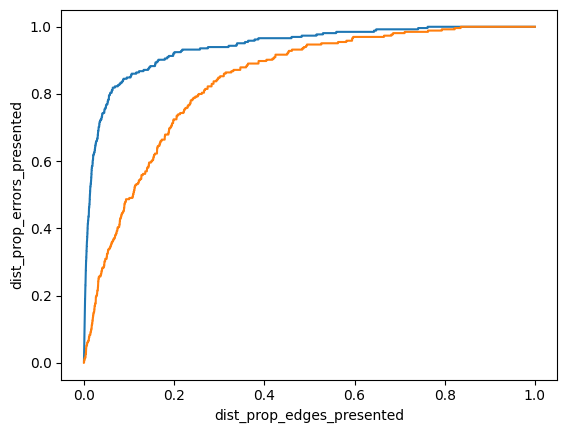

In [36]:
import seaborn as sns

of_interest = new_overall[new_overall.ds_name == ds_name][['ds_name', 'u', 'v', 'dist_prop_edges_presented', 'dist_prop_errors_presented', 'dist_prop_sampled_incorrect', 'sens_prop_edges_presented', 'sens_prop_errors_presented', 'sens_prop_sampled_incorrect']]
# dist_melted = of_interest.melt(id_vars=['ds_name', 'u', 'v', 'dist_prop_edges_presented'], value_vars=['dist_prop_errors_presented', 'dist_prop_sampled_incorrect'], var_name='prop_type', value_name='proportion')
# sens_melted = of_interest.melt(id_vars=['ds_name', 'u', 'v', 'sens_prop_edges_presented'], value_vars=['sens_prop_errors_presented', 'sens_prop_sampled_incorrect'], var_name='prop_type', value_name='proportion')

sns.lineplot(of_interest, x='dist_prop_edges_presented', y='dist_prop_errors_presented')
sns.lineplot(of_interest, x='sens_prop_edges_presented', y='sens_prop_errors_presented')

In [ ]:
# on average, how many incorrect edges can we find in that initial sample from **solution** edges
# by using the sensitivity_diff as a weight?
# we need sensitivity diff to be small in order for us to sample

# scaling sensitivity diff

# we first derive a scaled column - sensitivity_diff scaled to [0, 1] range
# then, we derive 1-scaled_sensitivity_diff. This means the smaller the initial diff, the more likely we are to sample it
# then for each dataset
# we take 30 samples of size 30:
# - just pure random sample
# - weighted by distance
# - weighted by inverse sensitivity diff thing
# and store the number of incorrect solution edges sampled, for each sampling type

# we also generate solutions disallowing merges and do the same thing?

In [41]:
fluo_edges = overall_df[overall_df.ds_name == 'PhC-C2DL-PSC_01']
len(fluo_edges)

281668

In [45]:
fluo_in_sol = fluo_edges[(fluo_edges.flow > 0) & (fluo_edges.u >= 0) & (fluo_edges.v >= 0)]
fluo_in_sol.sort_values(by='chosen_neighbour_rank', ascending=False)[:400]['solution_incorrect'].sum()


386

In [43]:
fluo_in_sol.sort_values(by='sensitivity_diff', ascending=True)[:100]['solution_incorrect'].sum()


38

In [44]:
fluo_in_sol.sort_values(by='chosen_neighbour_rank', ascending=False)[:400].tail()


,index,u,v,distance,capacity,cost,flow,chosen_neighbour_rank,chosen_neighbour_area_prop,sa_obj_low,sa_obj_up,sensitivity_diff,oracle_is_correct,solution_correct,solution_incorrect,ds_name
205322,205322,51330,51807,20.417383,2.0,20.417383,1.0,2,0.278351,16.158729,20.616465,0.199082,False,False,True,PhC-C2DL-PSC_01
262350,262350,65587,66152,20.826944,2.0,20.826944,1.0,2,0.652542,11.061716,22.750059,1.923115,False,False,True,PhC-C2DL-PSC_01
227746,227746,56936,57465,49.156281,2.0,49.156281,1.0,2,0.755981,-47.099687,104.782921,55.626640,False,False,True,PhC-C2DL-PSC_01
274710,274710,68677,69333,20.327336,2.0,20.327336,1.0,2,1.772727,-inf,22.770254,2.442919,False,False,True,PhC-C2DL-PSC_01
225162,225162,56290,56812,14.190768,2.0,14.190768,1.0,2,0.813559,-3.337756,14.519248,0.328481,False,False,True,PhC-C2DL-PSC_01
